####            Transfer Learning via InceptionV3
Code below is for transfer learning using inceptionv3 pretrined model.It id sone done to detect pnemoni in a given x-ray.


In [0]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize


Upload the imge data in the google drive and mount it.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Check the mounted google drive path and the list the directories

In [3]:

print(os.listdir('/content/drive/My Drive/chest_xray/chest_xray/'))

['test', 'val', 'train', '.DS_Store']


In [4]:
print(os.listdir("/content/drive/My Drive/chest_xray/chest_xray/train/"))

['PNEUMONIA', 'NORMAL', '.DS_Store']


In [0]:
TRAIN_DIR = "/content/drive/My Drive/chest_xray/chest_xray/train/"
TEST_DIR =  "/content/drive/My Drive/chest_xray/chest_xray/test/"
VAL_DIR =  "/content/drive/My Drive/chest_xray/chest_xray/val/"

In [0]:

def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [0]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [0]:
Pimages = os.listdir(TRAIN_DIR + "PNEUMONIA")
Nimages = os.listdir(TRAIN_DIR + "NORMAL")

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


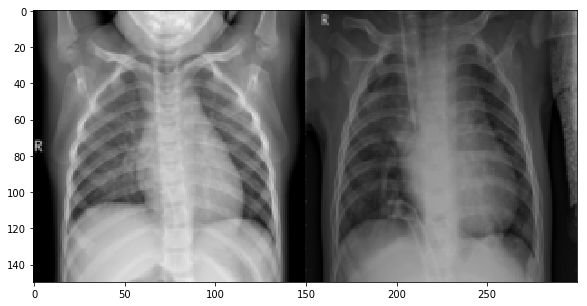

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


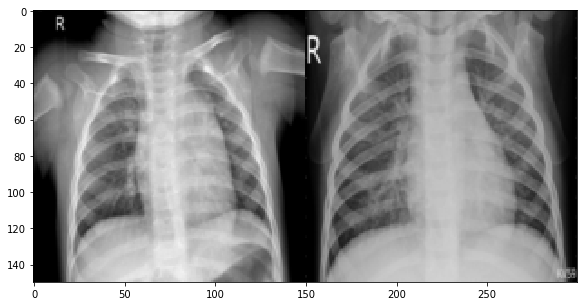

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


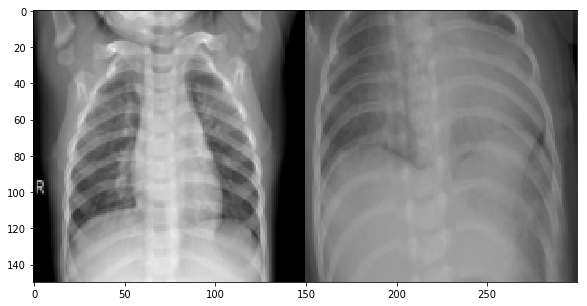

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


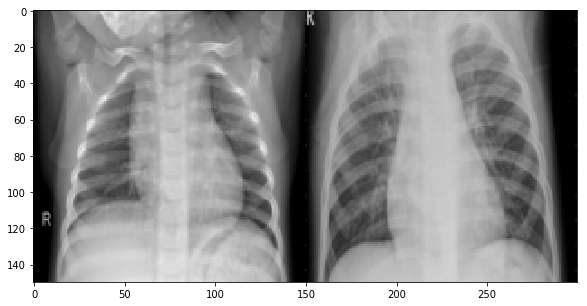

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


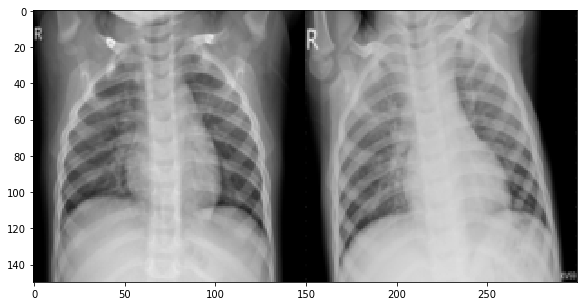

In [21]:
import matplotlib.pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(5,10):
  plotter(i)

#### Using the Inception V3 bas model

Steps:

- load the test, training and validation data
- set   
      - batch size, epoches, image height,image width, number of channels(depth)
- call ImageDataGenerator and create corresponding train, test, validation image generators. 
- Call the inception model with weights that of pretrained model. (here i have used imagenet  model weights) 

- use the inceptionV3 as base model. Further add dropout,pooling layer, and output layers to the model.

- Adjust the model parameters to get high training and validation accuracy, low loss

- compile the model with mentioning loss, optimizer, and accuracy

- Plot  model train, validation accuracy and loss graphs wrt epoch

- Evaluate the model using the test data. 
      -Get the evaluated accuracy and loss

- Compute the confusion metric


### Set

- batch size, epoches, image height,image width, number of channels(depth)

In [8]:
from keras.preprocessing.image import ImageDataGenerator

img_generator = ImageDataGenerator()

img_width, img_height,channel = 150, 150, 3
batch_size = 32
epochs = 10


Using TensorFlow backend.


### Create Train,Test, Validation image generators

In [9]:
train_img_generator = img_generator.flow_from_directory(
								TRAIN_DIR,
								target_size = (img_width,img_height),
								batch_size = batch_size,
								class_mode = 'categorical')

val_img_generator = img_generator.flow_from_directory(
								VAL_DIR,
								target_size = (img_width,img_height),
								class_mode = 'categorical')

test_img_generator = img_generator.flow_from_directory(
		                        TEST_DIR,
		                        target_size = (img_width,img_height),
		                        class_mode = 'categorical',
		                        batch_size= batch_size,
					            shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Create the Inception Model as base model

In [10]:
from keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False , input_shape=(150, 150,3))









87916544/87910968 [==============================] - 1s 0us/step


### Create the addtional Model layers


In [0]:

from keras.models import Sequential, Model
from keras.layers import Activation, Dense
from keras.optimizers import Adam
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Conv2D , BatchNormalization

In [12]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False
  
model.compile(loss='categorical_crossentropy',
			            optimizer=Adam(lr=0.001),
			            metrics=['accuracy'])
  
model.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_norm

### Create the defined model using "fit_generator"

In [13]:
history = model.fit_generator(train_img_generator,
	        steps_per_epoch = len(train_img_generator),
	        epochs = epochs,
          verbose=1,
	        validation_data = val_img_generator,
			    validation_steps = len(val_img_generator)
		)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
163/163 [==============================] - 1164s 7s/step - loss: 0.3090 - acc: 0.8758 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/10
163/163 [==============================] - 66s 406ms/step - loss: 0.2230 - acc: 0.9109 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 3/10
163/163 [==============================] - 69s 421ms/step - loss: 0.1874 - acc: 0.9247 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 4/10
163/163 [==============================] - 68s 418ms/step - loss: 0.2002 - acc: 0.9201 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 5/10
163/163 [==============================] - 68s 415ms/step - loss: 0.1888 - acc: 0.9266 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 6/10
163/163 [==============================] - 67s 414ms/step - loss: 0.1836 - acc: 0.9248 - val_loss: 10.0538 - val_acc: 0.3750
Epoch 7/10
163/163 [==============================] - 71s 433ms/step - loss: 0.1787 - acc: 0

In [14]:
test_accu = model.evaluate_generator(test_img_generator,steps=624 // batch_size)

print('Accuracy on test data is:', test_accu[1])
print('Loss on test data is:', test_accu[0])

Accuracy on test data is: 0.3092105263157895
Loss on test data is: 10.985522609007987


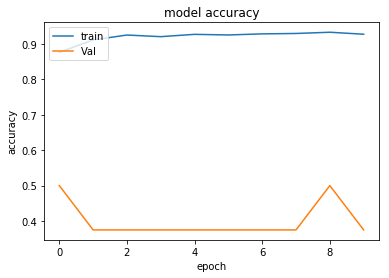

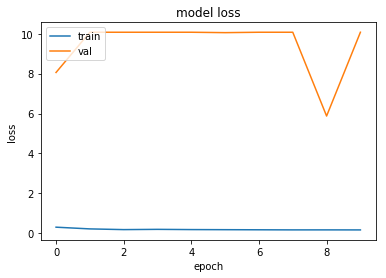

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(299, 299, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [27]:
X_test , y_test = get_data(TEST_DIR)

100%|██████████| 390/390 [00:59<00:00,  4.51it/s]


In [37]:
print("results")
y_pred = model.predict_generator(test_img_generator, steps=len(test_img_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_img_generator.classes

results
20/20 [==============================] - 7s 354ms/step


------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 17.14%
Recall        : 3.08%
F1-Score      : 5.22%
------------------------------------------------------------------------------------------





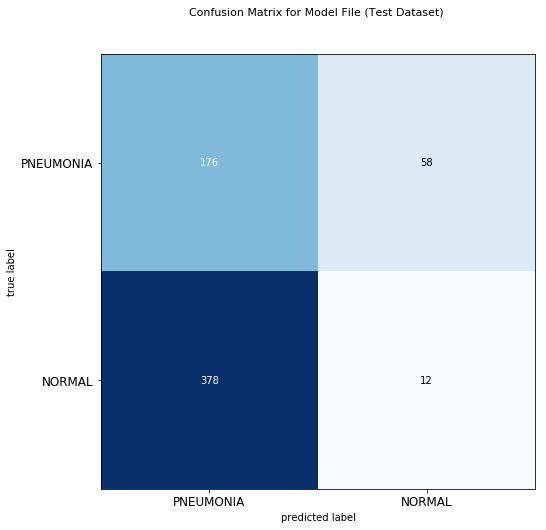

In [43]:

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from mlxtend.plotting import plot_confusion_matrix

classes=['PNEUMONIA', 'NORMAL']

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Confusion Matrix for Model File (Test Dataset) \n", fontsize=11)

plt.show()
